# Model Prototyping

## 1. Loading Featured Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

In [2]:
sns.set_theme(style="whitegrid")
pd.set_option('display.max_columns', 100)

In [3]:
FEATURED_DATA_PATH = "../data/processed/featured_dataset"
df = pd.read_parquet(FEATURED_DATA_PATH)

print(f"Featured dataset loaded successfully. It has {df.shape[0]} rows and {df.shape[1]} columns.")
df.head()

Featured dataset loaded successfully. It has 36457 rows and 23 columns.


,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,Risk_Flag,AGE,IS_UNEMPLOYED,YEARS_EMPLOYED,INCOME_PER_PERSON
0,5089051,M,N,N,0,225000.0,Working,Higher education,Married,House / apartment,-13231,-3139,1,1,1,0,Sales staff,2.0,0,36.249315,0,8.600000,112500.0
1,5125602,F,Y,Y,0,450000.0,Commercial associate,Higher education,Married,House / apartment,-10149,-2783,1,0,0,0,Accountants,2.0,0,27.805479,0,7.624658,225000.0
2,5047848,M,Y,Y,0,315000.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-21871,-979,1,0,0,0,Drivers,2.0,0,59.920548,0,2.682192,157500.0
3,5009994,M,Y,Y,1,360000.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-13940,-617,1,0,0,0,Managers,3.0,0,38.191781,0,1.690411,120000.0
4,5066783,M,Y,N,1,157500.0,Working,Secondary / secondary special,Married,House / apartment,-15567,-2014,1,0,0,0,Drivers,3.0,0,42.649315,0,5.517808,52500.0


## 2. Data Preprocessing for Modeling

In [4]:
# Target
y = df['Risk_Flag']
# Features
X = df.drop(columns=['Risk_Flag', 'ID', 'DAYS_BIRTH', 'DAYS_EMPLOYED'])

# Categorical features
categorical_features = X.select_dtypes(include=['object']).columns
# Numerical features
numerical_features = X.select_dtypes(include=np.number).columns

print("Categorical features:", list(categorical_features))
print("Numerical features:", list(numerical_features))

Categorical features: ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE']
Numerical features: ['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'AGE', 'IS_UNEMPLOYED', 'YEARS_EMPLOYED', 'INCOME_PER_PERSON']


In [5]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Training shape:", X_train.shape)
print("Testing shape:", X_test.shape)

Training shape: (29165, 19)
Testing shape: (7292, 19)


In [6]:
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
], remainder='passthrough')

## 3. Train and Compare Models

### 3.1 Method 1: Class Weighting

This method does not change the data itself. It keeps the original imbalanced training set. Instead, it changes the learning algorithm's loss function. It tells the model, "When you make a mistake on a minority class sample, the penalty (the loss) is much, much higher than if you make a mistake on a majority class sample."

* `class_weight='balanced'` automatically calculates this penalty to be inversely proportional to the class frequencies.
* `scale_pos_weight` in XGBoost does the same thing specifically for the positive class.

In [25]:
# Calculate scale_pos_weight for XGBoost
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

# Define Models
models = {
    "Logistic Regression": LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000, solver='liblinear'),
    "Random Forest": RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1),
    "XGBoost": XGBClassifier(random_state=42, scale_pos_weight=scale_pos_weight)
}

In [26]:
# Train and Evaluate Models
results = {}
for name, model in models.items():
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                  ('classifier', model)])

    print(f"Training {name} with class weighting")
    pipeline.fit(X_train, y_train)

    # Predict probabilities for AUC calculation
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_pred_proba)
    results[name] = auc

    print(f"AUC-ROC Score for {name}: {auc:.4f}")
    print("-" * 50)

Training Logistic Regression with class weighting
AUC-ROC Score for Logistic Regression: 0.5735
--------------------------------------------------
Training Random Forest with class weighting
AUC-ROC Score for Random Forest: 0.8110
--------------------------------------------------
Training XGBoost with class weighting
AUC-ROC Score for XGBoost: 0.7334
--------------------------------------------------


In [27]:
# Store the best pipeline for later use
best_model_name = max(results, key=results.get)
print(f"Best performing model: {best_model_name} with AUC = {results[best_model_name]:.4f}")

Best performing model: Random Forest with AUC = 0.8110


In [28]:
# Re-train the best pipeline to save it
best_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                ('classifier', models[best_model_name])])
best_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  Index(['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'FLAG_MOBIL', 'FLAG_WORK_PHONE',
       'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'AGE', 'IS_UNEMPLOYED',
       'YEARS_EMPLOYED', 'INCOME_PER_PERSON'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  Index(['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_INCOME_TYPE',
       'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'OCCUPATION_TYPE'],
      dtype='object'))])),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced', n_jobs=-1,
                                        random_state=42))])

### 3.2 Method 2: Resampling (SMOTE)

This method changes the data before it gets to the model. It directly addresses the data imbalance by creating a new, balanced training set. SMOTE does this intelligently by creating synthetic new samples of the minority class, effectively giving the model more diverse examples to learn from.

In [30]:
# Define Models
models_smote = {
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000, solver='liblinear'),
    "Random Forest": RandomForestClassifier(random_state=42, n_jobs=-1),
    "XGBoost": XGBClassifier(random_state=42)
}

In [31]:
# Train and Evaluate Models
results_smote = {}
for name, model in models_smote.items():
    pipeline_imb = ImbPipeline(steps=[('preprocessor', preprocessor), 
                                  ('smote', SMOTE(random_state=42)),
                                  ('classifier', model)])

    print(f"Training {name} with SMOTE")
    pipeline_imb.fit(X_train, y_train)

    # Predict probabilities for AUC calculation
    y_pred_proba = pipeline_imb.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_pred_proba)
    results_smote[name] = auc

    print(f"AUC-ROC Score for {name}: {auc:.4f}")
    print("-" * 50)

Training Logistic Regression with SMOTE
AUC-ROC Score for Logistic Regression: 0.5694
--------------------------------------------------
Training Random Forest with SMOTE
AUC-ROC Score for Random Forest: 0.8300
--------------------------------------------------
Training XGBoost with SMOTE
AUC-ROC Score for XGBoost: 0.7003
--------------------------------------------------


In [33]:
# Store the best pipeline for later use
best_model_name_smote = max(results_smote, key=results_smote.get)
print(f"Best performing model: {best_model_name_smote} with AUC = {results_smote[best_model_name_smote]:.4f}")

Best performing model: Random Forest with AUC = 0.8300


In [34]:
# Re-train the best pipeline to save it
best_pipeline_imb = ImbPipeline(steps=[('preprocessor', preprocessor),
                                   ('smote', SMOTE(random_state=42)),
                                   ('classifier', models_smote[best_model_name_smote])])
best_pipeline_imb.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  Index(['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'FLAG_MOBIL', 'FLAG_WORK_PHONE',
       'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'AGE', 'IS_UNEMPLOYED',
       'YEARS_EMPLOYED', 'INCOME_PER_PERSON'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  Index(['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_INCOME_TYPE',
       'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'OCCUPATION_TYPE'],
      dtype='object'))])),
                ('smote', SMOTE(random_state=42)),
                ('classifier',
                 RandomForestClassifier(n_jobs=-1, random_state=42))])

## 4. Analyze the Best Model

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      7169
           1       0.21      0.45      0.28       123

    accuracy                           0.96      7292
   macro avg       0.60      0.71      0.63      7292
weighted avg       0.98      0.96      0.97      7292


Confusion Matrix:


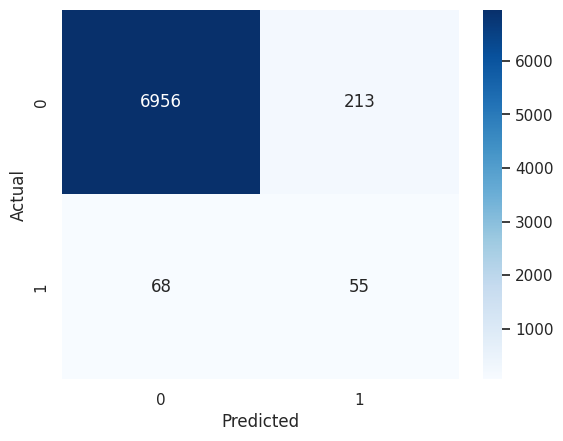

In [ ]:
# --- 1. Report for the Best Model with class weighting ---
y_pred_best = best_pipeline.predict(X_test)

print(classification_report(y_test, y_pred_best))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

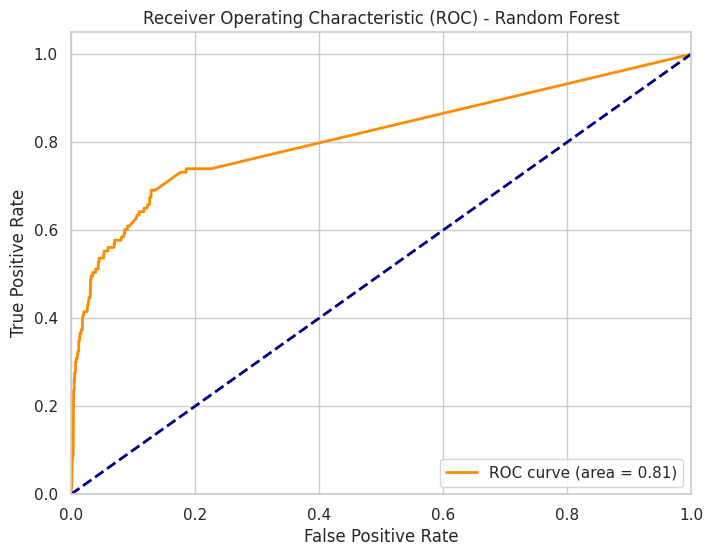

In [38]:
# Plot ROC Curve
y_pred_proba_best = best_pipeline.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_best)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {results[best_model_name]:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver Operating Characteristic (ROC) - {best_model_name}')
plt.legend(loc="lower right")
plt.show()

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      7169
           1       0.37      0.31      0.34       123

    accuracy                           0.98      7292
   macro avg       0.68      0.65      0.66      7292
weighted avg       0.98      0.98      0.98      7292


Confusion Matrix:


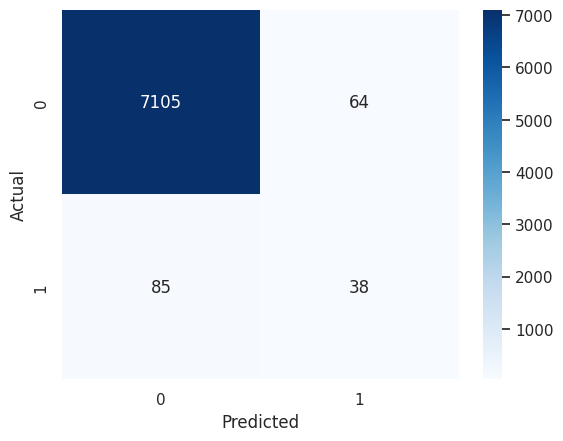

In [ ]:
# --- 2. Report for the Best Model with SMOTE ---
y_pred_best_smote = best_pipeline_imb.predict(X_test)

print(classification_report(y_test, y_pred_best_smote))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred_best_smote)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

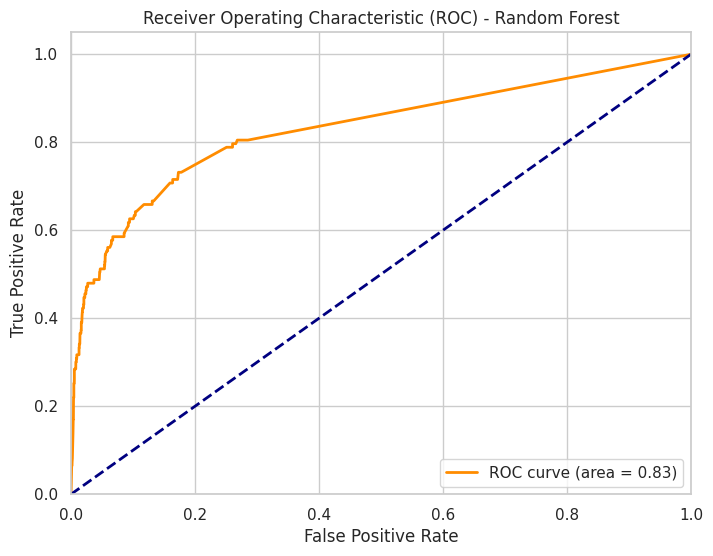

In [37]:
# Plot ROC Curve
y_pred_proba_best_smote = best_pipeline_imb.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_best_smote)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {results_smote[best_model_name_smote]:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver Operating Characteristic (ROC) - {best_model_name_smote}')
plt.legend(loc="lower right")
plt.show()

## 5. Save the Prototyped Model 

In [40]:
# Save the best pipeline object for later use or inspection
# This is the "prototype" model
PROTOTYPE_MODEL_PATH = "../models/prototype_credit_risk_pipeline_with_smote.joblib"
print(f"Saving prototype model to {PROTOTYPE_MODEL_PATH}")
joblib.dump(best_pipeline_imb, PROTOTYPE_MODEL_PATH)

Saving prototype model to ../models/prototype_credit_risk_pipeline_with_smote.joblib


['../models/prototype_credit_risk_pipeline_with_smote.joblib']